In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from scipy.spatial.transform import Rotation as R

In [2]:
DATASET_PATH = "dataset.h5"
INTRINSICS = {"focalLength": 1.0, "width": 384.0, "height": 256.0, "zRange": [0.01, 2.0]}
VIEW_IDX = 3

In [3]:
with h5py.File(DATASET_PATH, "r") as f:
    dp_key = next(iter(f.keys()))
    for k, v in f[dp_key].items():
        print(f"{k:<12} {v.shape}")

cam_poses    (4, 7)
depths       (4, 256, 384)
feasibles    (7, 8)
final_poses  (7, 8, 7)
images       (4, 256, 384, 3)
obj_ids      (7,)
poses        (7, 7)
seg_ids      (4, 256, 384)
sizes        (7, 3)
target_poses (7, 7)


In [4]:
def create_distance_map(target_poses, cam_pose, depth):
    h, w = int(INTRINSICS["height"]), int(INTRINSICS["width"])
    f = INTRINSICS["focalLength"]
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")

    # Unproject to camera space
    x = (X - w / 2) / (w / 2) * depth / f
    y = (Y - h / 2) / (h / 2) * depth / f
    pts_cam = np.stack([x, y, depth], axis=-1)

    # Transform to world space
    rot = R.from_quat(np.roll(cam_pose[3:], -1)).as_matrix()
    pts_world = (rot @ pts_cam.reshape(-1, 3).T).T.reshape(h, w, 3) + cam_pose[:3]

    # Compute distances
    dists = [np.linalg.norm(pts_world - pose[:3], axis=-1) for pose in target_poses]
    return np.stack(dists).astype(np.float32)

In [5]:
with h5py.File(DATASET_PATH, "r") as f:
    all_keys = list(f.keys())
    n_samples = int(len(all_keys) * 0.2)
    sample_keys = np.random.choice(all_keys, size=n_samples, replace=False)

    depths = []
    dists = []
    target_positions = []

    for key in tqdm.tqdm(sample_keys):
        dp = f[key]
        cam_pose = dp["cam_poses"][VIEW_IDX][()]
        depth = dp["depths"][VIEW_IDX][()]
        target_poses = dp["target_poses"][()]

        depths.append(depth)
        dists.append(create_distance_map(target_poses, cam_pose, depth).flatten())
        target_positions.append(target_poses[:, :3])

depths = np.concatenate(depths)
dists = np.concatenate(dists)
target_positions = np.concatenate(target_positions)

  0%|          | 0/2199 [00:00<?, ?it/s]

100%|██████████| 2199/2199 [00:40<00:00, 54.50it/s]


In [16]:
depth_min = depths.min()
depth_max = depths.max()
dist_max = dists.max()

pos_min = target_positions.min(axis=0)
pos_max = target_positions.max(axis=0)
pos_range = pos_max - pos_min

pos_mean = target_positions.mean(axis=0)
pos_std = target_positions.std(axis=0)

print(f"depth:    [{depth_min:.4f}, {depth_max:.4f}], mean={depths.mean():.4f}")
print(f"distance: [{dists.min():.4f}, {dist_max:.4f}], mean={dists.mean():.4f}")
print(f"pos:      [{pos_min}, {pos_max}], mean={pos_mean}, std={pos_std}, range={pos_range}")

depth:    [0.5448, 1.2218], mean=0.8247
distance: [0.0008, 2.3760], mean=0.7375
pos:      [[-0.76836795 -0.29652196  0.07000764], [0.75859326 0.7843678  0.09999678]], mean=[0.00084826 0.26619914 0.08503196], std=[0.32931465 0.19167422 0.00868788], range=[1.5269612  1.0808897  0.02998914]


In [ ]:
with h5py.File(DATASET_PATH, "r") as f_in, h5py.File("dataset-pos-ori.h5", "w") as f_out:
    f_out.attrs.update(f_in.attrs)
    f_out.attrs["depth_min"] = depth_min
    f_out.attrs["depth_max"] = depth_max
    f_out.attrs["dist_max"] = dist_max
    f_out.attrs["pos_min"] = pos_min
    f_out.attrs["pos_max"] = pos_max

    for key in tqdm.tqdm(f_in.keys()):
        dp = f_in[key]

        obj_ids = dp["obj_ids"][()]
        cam_pose = dp["cam_poses"][VIEW_IDX][()]
        seg = dp["seg_ids"][VIEW_IDX]
        poses = dp["poses"][()]
        target_poses = dp["target_poses"][()]
        feasibles = dp["feasibles"][()]

        depth_raw = dp["depths"][VIEW_IDX][()]
        depth = (depth_raw - depth_min) / (depth_max - depth_min)

        dist_maps = create_distance_map(target_poses, cam_pose, depth_raw)
        dist_maps = np.clip(dist_maps / dist_max, 0.0, 1.0)

        for i in range(len(obj_ids)):
            grp = f_out.create_group(f"{key}_obj_{i}")

            grp.create_dataset("depth", data=depth)
            grp.create_dataset("mask", data=(seg == obj_ids[i]).astype(np.float32))
            grp.create_dataset("dist_map", data=dist_maps[i])
            grp.create_dataset("quat", data=poses[i][3:])

            target_pos = target_poses[i][:3]
            target_quat = target_poses[i][3:]
            target_pos = (target_pos - pos_min) / (pos_range)

            grp.create_dataset("target_pos", data=target_pos)
            grp.create_dataset("target_quat", data=target_quat)
            grp.create_dataset("target_pose", data=np.concatenate([target_pos, target_quat]))
            grp.create_dataset("feasibles", data=feasibles[i])

  0%|          | 9/10996 [00:00<04:16, 42.77it/s]

100%|██████████| 10996/10996 [05:47<00:00, 31.67it/s]


In [18]:
def visualize_sample(depth, mask, dist_map, threshold=0.1):
    _, ax = plt.subplots(figsize=(8, 8))

    img = np.stack([depth, depth, depth], axis=-1)
    img[mask > 0.5, 1] += 0.5
    img[:, :, 0] += ((1 - dist_map / threshold).clip(0, 1) ** 2) * 0.7
    img = img.clip(0, 1)

    ax.imshow(img)
    ax.axis("off")
    plt.tight_layout()

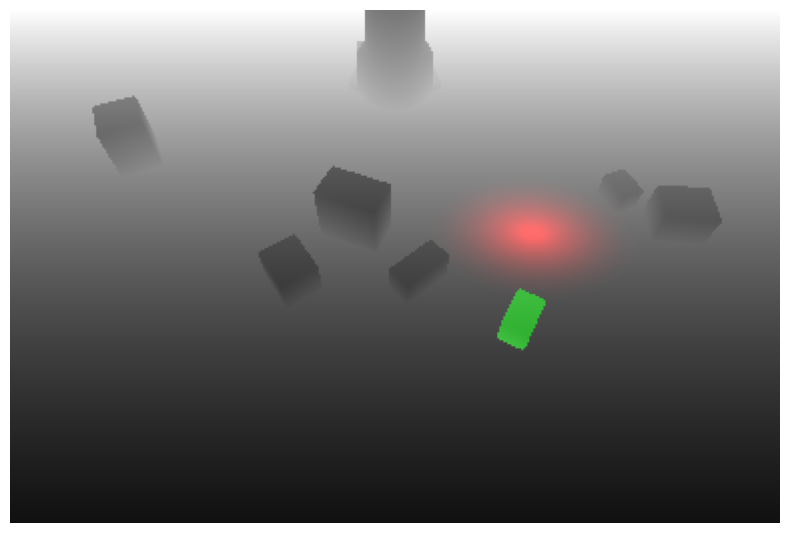

In [ ]:
with h5py.File("dataset-pos-ori.h5", "r") as f:
    dp = f[list(f.keys())[3]]
    visualize_sample(dp["depth"][()], dp["mask"][()], dp["dist_map"][()])